# Competition - Jigsaw Unintended Bias in Toxicity Classification (JUBTC)

Detect toxicity across a diverse range of conversations

**The Challenge** - "Detect toxic comments ― and minimize unintended model bias. That's your challenge in this competition."

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

# Loading data from Kaggle

You may need to use the Kaggle API token to load data into Google Colab environment.

**Note** - This is only for Google Colab users.

In [1]:
#!pip install kaggle

In [2]:
#!mkdir ~/.kaggle
#!cp /content/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#!kaggle competitions download jigsaw-unintended-bias-in-toxicity-classification

In [4]:
#!unzip *.zip

# Importing Libraries

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Data Preparation

In [7]:
# For Kaggle Users
dataframe_train = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
dataframe_test = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

# For Google Colab Users
#dataframe_train = pd.read_csv('/content/train.csv')
#dataframe_test = pd.read_csv('/content/test.csv')

In [8]:
dataframe_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [9]:
dataframe_test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [10]:
dataframe_train.count()

id                                     1804874
target                                 1804874
comment_text                           1804874
severe_toxicity                        1804874
obscene                                1804874
identity_attack                        1804874
insult                                 1804874
threat                                 1804874
asian                                   405130
atheist                                 405130
bisexual                                405130
black                                   405130
buddhist                                405130
christian                               405130
female                                  405130
heterosexual                            405130
hindu                                   405130
homosexual_gay_or_lesbian               405130
intellectual_or_learning_disability     405130
jewish                                  405130
latino                                  405130
male         

In [11]:
dataframe_test.count()

id              97320
comment_text    97320
dtype: int64

## Dataframe Properties

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).

The data also has several additional toxicity subtype attributes. Models do not need to predict these attributes for the competition, they are included as an additional avenue for research. Subtype attributes are:

* severe_toxicity
* obscene
* threat
* insult
* identity_attack
* sexual_explicit

Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.

* male
* female
* transgender
* other_gender
* heterosexual
* homosexual_gay_or_lesbian
* bisexual
* other_sexual_orientation
* christian
* jewish
* muslim
* hindu
* buddhist
* atheist
* other_religion
* black
* white
* asian
* latino
* other_race_or_ethnicity
* physical_disability
* intellectual_or_learning_disability
* psychiatric_or_mental_illness
* other_disability

In [12]:
dataframe_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3.738434e+06,2.445187e+06,59848.0,796975.25,5223774.5,5.769854e+06,6334010.00
target,1804874.0,1.030173e-01,1.970757e-01,0.0,0.00,0.0,1.666667e-01,1.00
severe_toxicity,1804874.0,4.582099e-03,2.286128e-02,0.0,0.00,0.0,0.000000e+00,1.00
obscene,1804874.0,1.387721e-02,6.460419e-02,0.0,0.00,0.0,0.000000e+00,1.00
identity_attack,1804874.0,2.263571e-02,7.873156e-02,0.0,0.00,0.0,0.000000e+00,1.00
insult,1804874.0,8.115273e-02,1.760657e-01,0.0,0.00,0.0,9.090909e-02,1.00
threat,1804874.0,9.311271e-03,4.942218e-02,0.0,0.00,0.0,0.000000e+00,1.00
asian,405130.0,1.196355e-02,8.716616e-02,0.0,0.00,0.0,0.000000e+00,1.00
atheist,405130.0,3.205019e-03,5.019273e-02,0.0,0.00,0.0,0.000000e+00,1.00
bisexual,405130.0,1.884285e-03,2.607737e-02,0.0,0.00,0.0,0.000000e+00,1.00


In [13]:
dataframe_train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

Lots of null values seen in training set

In [14]:
dataframe_test.isnull().sum()

id              0
comment_text    0
dtype: int64

No nulls in test set

# Data Preprocessing

The following are the steps in our data preprocessing phase - 



*   Dropping null values
*   TF-IDF Vectorization
*   Splitting in to dependent(Y) and independent(X) variables



## Dropping null values

In [15]:
dataframe_train.dropna(axis=1, inplace=True)

In [16]:
dataframe_train.isnull().sum()

id                          0
target                      0
comment_text                0
severe_toxicity             0
obscene                     0
identity_attack             0
insult                      0
threat                      0
created_date                0
publication_id              0
article_id                  0
rating                      0
funny                       0
wow                         0
sad                         0
likes                       0
disagree                    0
sexual_explicit             0
identity_annotator_count    0
toxicity_annotator_count    0
dtype: int64

## TF - IDF Vectorization

TF-IDF stands for Term Frequency Inverse Document Frequency of records. It can be defined as the calculation of how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus.

Creating a matrix of TF-IDF features.

In [17]:
Vectorize = TfidfVectorizer()

In [18]:
X_train = Vectorize.fit_transform(dataframe_train["comment_text"])

In [19]:
X_test = Vectorize.transform(dataframe_test["comment_text"])

In [20]:
Y_train = np.where(dataframe_train['target'] >= 0.5, 1, 0)

## Splitting into X and Y

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=1/3, random_state=42)

# Exploratory Data Analysis

Exploratory data analysis (EDA) is leveraged to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods


**We do our EDA in 2 parts**


*   WordCloud Plots
*   Distribution Plot



## WordClouds

A plot composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.

Plotting a WordCloud for Comments with Threat scores

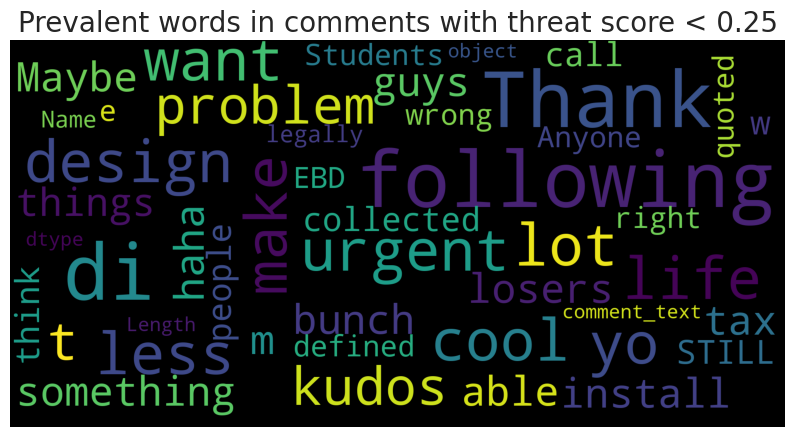

In [22]:
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe_train.loc[dataframe_train['threat'] < 0.25]['comment_text']))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title(label = 'Prevalent words in comments with threat score < 0.25', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

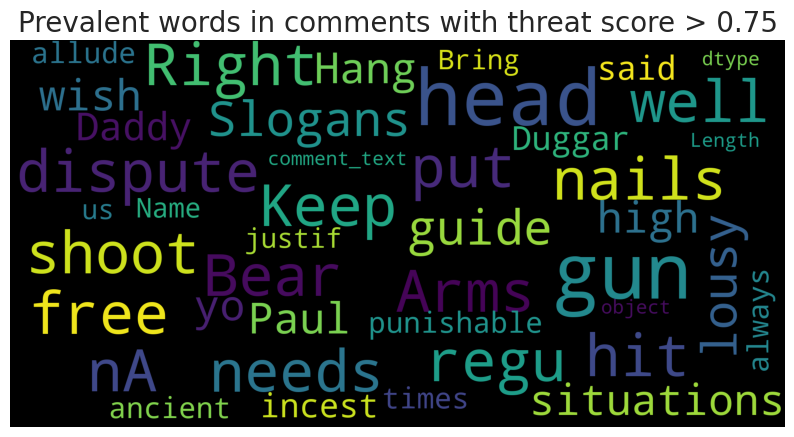

In [23]:
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe_train.loc[dataframe_train['threat'] > 0.75]['comment_text']))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title(label = 'Prevalent words in comments with threat score > 0.75', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

WordCloud Plots for Comments on the basis of insult scores

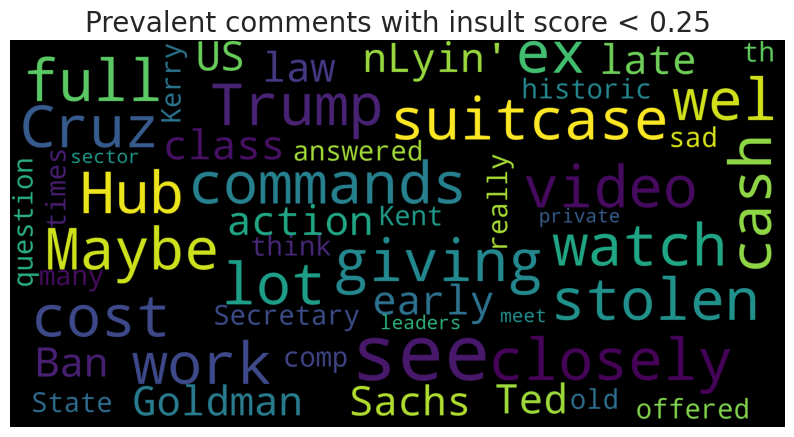

In [24]:
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe_train.loc[dataframe_train['insult'] < 0.25]['comment_text'].sample(20000)))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title(label = 'Prevalent comments with insult score < 0.25', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

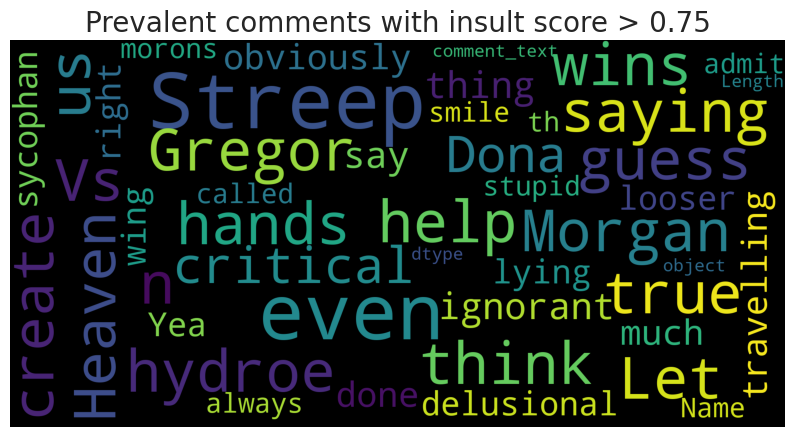

In [25]:
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe_train.loc[dataframe_train['insult'] > 0.75]['comment_text'].sample(20000)))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title(label = 'Prevalent comments with insult score > 0.75', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

WordCloud Plot for Most Ocurring Words in Training dataset

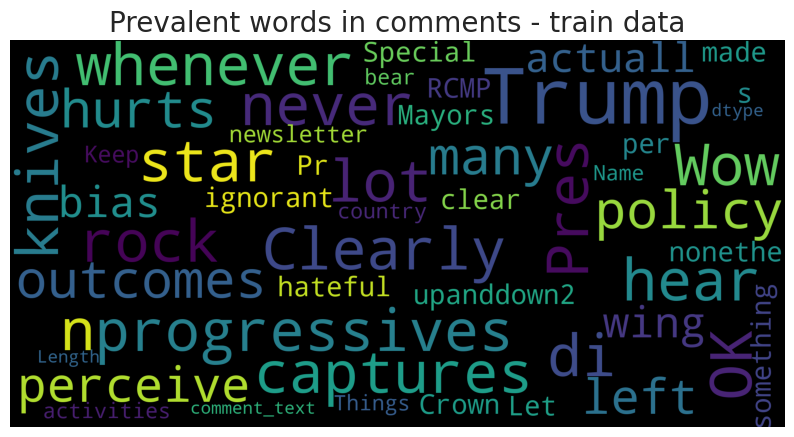

In [26]:
wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(dataframe_train['comment_text'].sample(20000)))

fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title(label = 'Prevalent words in comments - train data', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(wordcloud)
plt.show()

## DistPlot

A Distplot or distribution plot, depicts the variation in the data distribution. Seaborn Distplot represents the overall distribution of continuous data variables.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


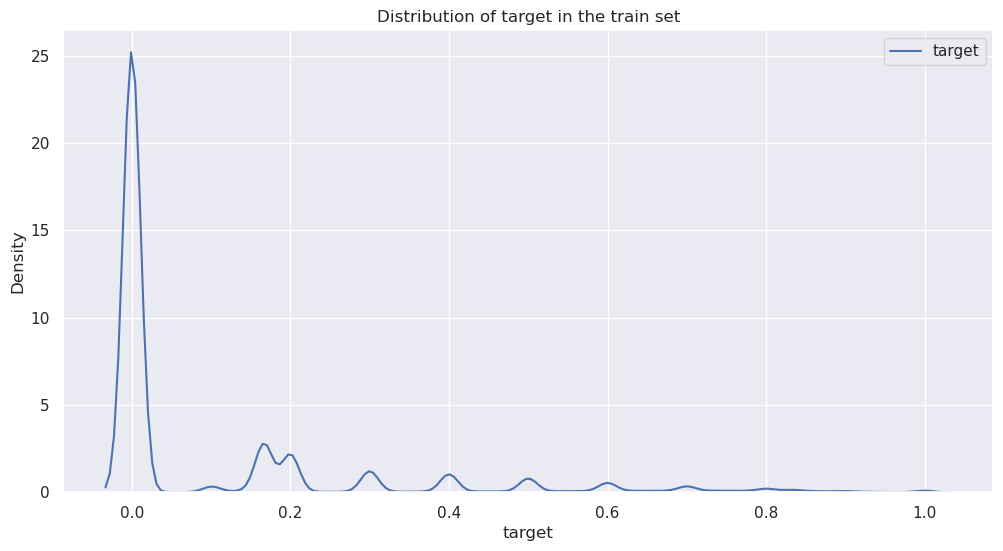

In [27]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(dataframe_train['target'],kde=True,hist=False, bins=120, label='target')
plt.legend()
plt.show()

# Machine Learning Model Building

We aim to build the following Machine Learning Models


1.   Bernoulli Naive Bayes
2.   Logistic Regression
3.   Support Vector Classifier with a Linear Kernel
4.   Support Vector Classifier with a RBF Kernel
5.   KNeighbors Classifier
6.   Decision Tree Classifier
7.   Random Forest Classifier
8.   MLP Classifier

We then cross validate and score these models on Accuracy and F1 Score.

Analyze their ROC curves.

Analyze their Confusion Matrices

Then we choose top 3 models.

Select the best model and tune it and create final submissions.

**Bernoulli Naive Bayes**

Bernoulli Naive Bayes is a part of the Naive Bayes family. It is based on the Bernoulli Distribution and accepts only binary values, i.e., 0 or 1. If the features of the dataset are binary, then we can assume that Bernoulli Naive Bayes is the algorithm to be used.

In [28]:
nb = BernoulliNB(alpha=1.0,fit_prior=True)
nb.fit(X_train, Y_train)

BernoulliNB()

In [29]:
cv_accuracy = cross_val_score(nb, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
nb_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",nb_cv_accuracy)

First fold accuracy  :  0.8541475169636342
Second fold accuracy :  0.8567555353074603
Third fold accuracy  :  0.8533203647488237
Fourth fold accuracy :  0.8495103608548473
Fifth fold accuracy  :  0.8559654965417471
Mean CV (ROC-AUC) Accuracy :  0.8539398548833026


In [30]:
cv_f1 = cross_val_score(nb, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
nb_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",nb_cv_f1)

First fold F1  :  0.9141642754637391
Second fold F1 :  0.9153118921363627
Third fold F1  :  0.9145467340786106
Fourth fold F1 :  0.914472519852362
Fifth fold F1  :  0.9142985072831674
Mean CV F1 Score :  0.9145587857628483


In [31]:
Y_pred = nb.predict(X_test)

In [32]:
nb_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of Bernoulli Naive Bayes is :", nb_acc)

The accuracy of Bernoulli Naive Bayes is : 0.920590068564305


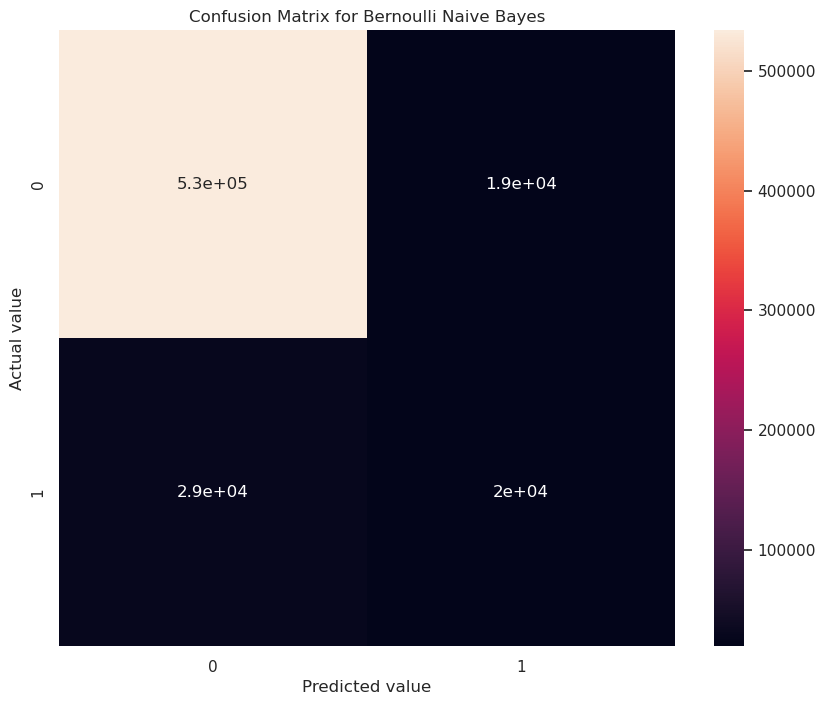

In [33]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Bernoulli Naive Bayes")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [34]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    553213
           1       0.51      0.41      0.45     48412

    accuracy                           0.92    601625
   macro avg       0.73      0.69      0.71    601625
weighted avg       0.91      0.92      0.92    601625



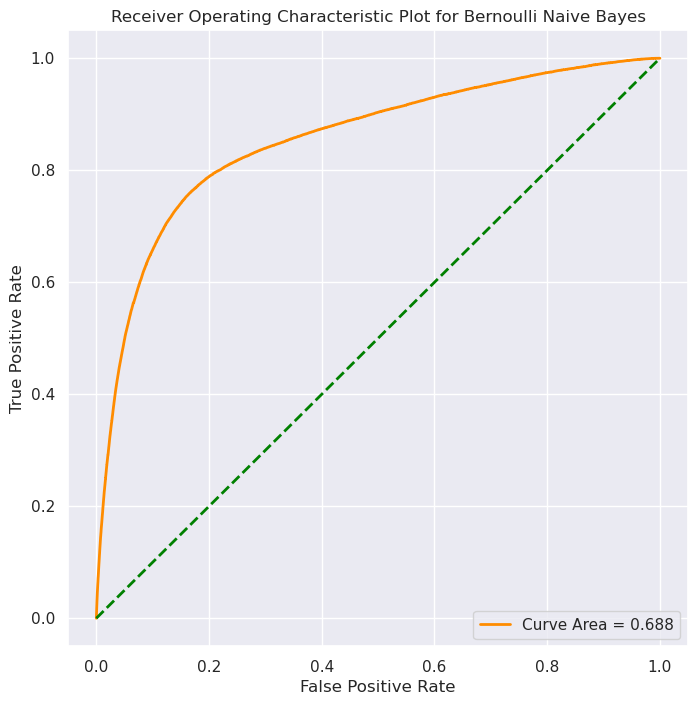

In [35]:
fpr, tpr, thr = roc_curve(Y_test, nb.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Bernoulli Naive Bayes')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression**

In regression analysis, logistic regression is estimating the parameters of a logistic model(logistic model is a statistical model that models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables.)



In [36]:
lr = LogisticRegression(C=5, random_state=42, solver='sag', max_iter=1000, n_jobs=-1, verbose = 0)
lr.fit(X_train, Y_train)

LogisticRegression(C=5, max_iter=1000, n_jobs=-1, random_state=42, solver='sag')

In [37]:
cv_accuracy = cross_val_score(lr, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
lr_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",lr_cv_accuracy)

First fold accuracy  :  0.9429224706252106
Second fold accuracy :  0.9440869777899438
Third fold accuracy  :  0.9427682121590852
Fourth fold accuracy :  0.9429150854209684
Fifth fold accuracy  :  0.9443728359027883
Mean CV (ROC-AUC) Accuracy :  0.9434131163795992


In [38]:
cv_f1 = cross_val_score(lr, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1 : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
lr_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",lr_cv_f1)

First fold F1 :  0.9422623429538918
Second fold F1 :  0.9427137224842824
Third fold F1  :  0.9425346246503085
Fourth fold F1 :  0.9416569776286984
Fifth fold F1  :  0.9428379331330161
Mean CV F1 Score :  0.9424011201700395


In [39]:
Y_pred = lr.predict(X_test)

In [40]:
lr_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of Logistic Regressor is :", lr_acc)

The accuracy of Logistic Regressor is : 0.9472029918969458


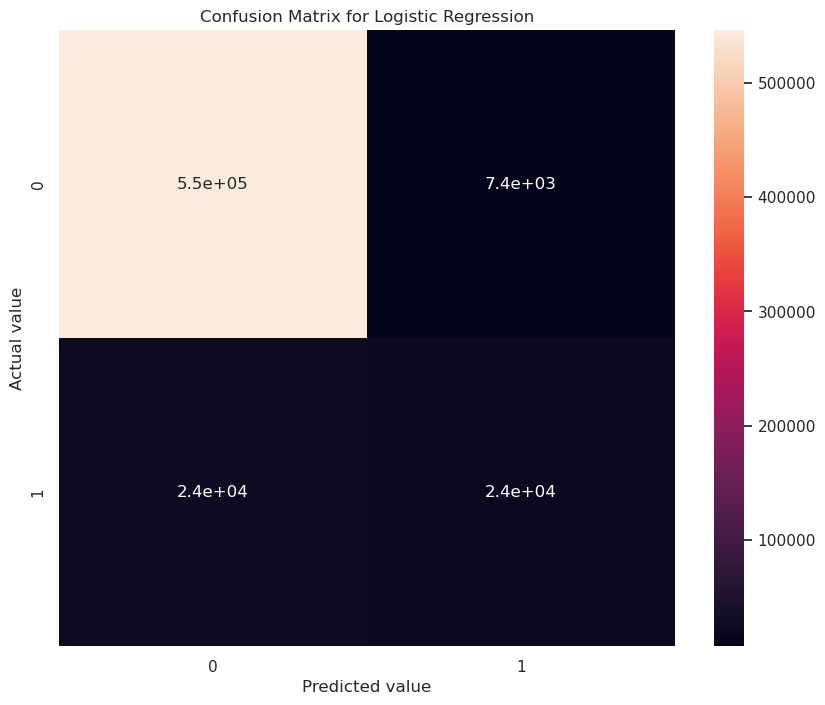

In [41]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Logistic Regression")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [42]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    553213
           1       0.77      0.50      0.60     48412

    accuracy                           0.95    601625
   macro avg       0.86      0.74      0.79    601625
weighted avg       0.94      0.95      0.94    601625



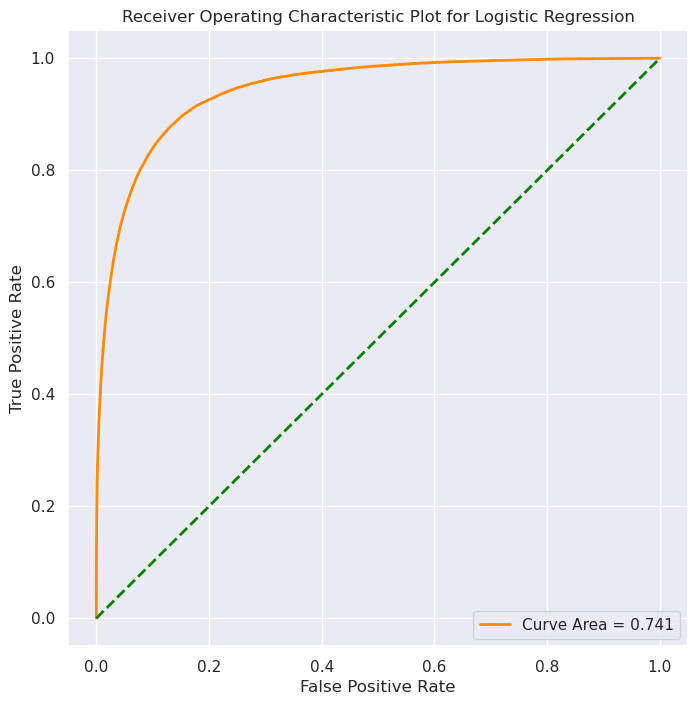

In [43]:
fpr, tpr, thr = roc_curve(Y_test, lr.predict_proba(X_test)[:,1])
#auc = auc(fpr, tpr)
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

**Support Vector Classifier with a Linear Kernel**

Coming from the family of Support Vector Machines, Linear Support Vector Machine (Linear SVC) is an algorithm that attempts to find a hyperplane to maximize the distance between classified samples.

In [44]:
svc_lin = SVC(kernel = "linear", verbose = False, max_iter = 20, probability = True)
svc_lin.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(kernel='linear', max_iter=20, probability=True)

In [45]:
cv_accuracy = cross_val_score(svc_lin, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
svc_lin_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",svc_lin_cv_accuracy)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: Conve

First fold accuracy  :  0.526379791398122
Second fold accuracy :  0.5320811688292859
Third fold accuracy  :  0.5164952509216987
Fourth fold accuracy :  0.5661751627035032
Fifth fold accuracy  :  0.48215826260970074
Mean CV (ROC-AUC) Accuracy :  0.5246579272924621


In [46]:
cv_f1 = cross_val_score(svc_lin, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
svc_lin_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",svc_lin_cv_f1)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


First fold F1  :  0.8275859778224699
Second fold F1 :  0.23515618732097812
Third fold F1  :  0.8792283219014615
Fourth fold F1 :  0.8400941962619184
Fifth fold F1  :  0.8435049777102235
Mean CV F1 Score :  0.7251139322034102


In [47]:
Y_pred = svc_lin.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


In [48]:
svc_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of Linear SVC is :", svc_acc)

The accuracy of Linear SVC is : 0.9192021608144608


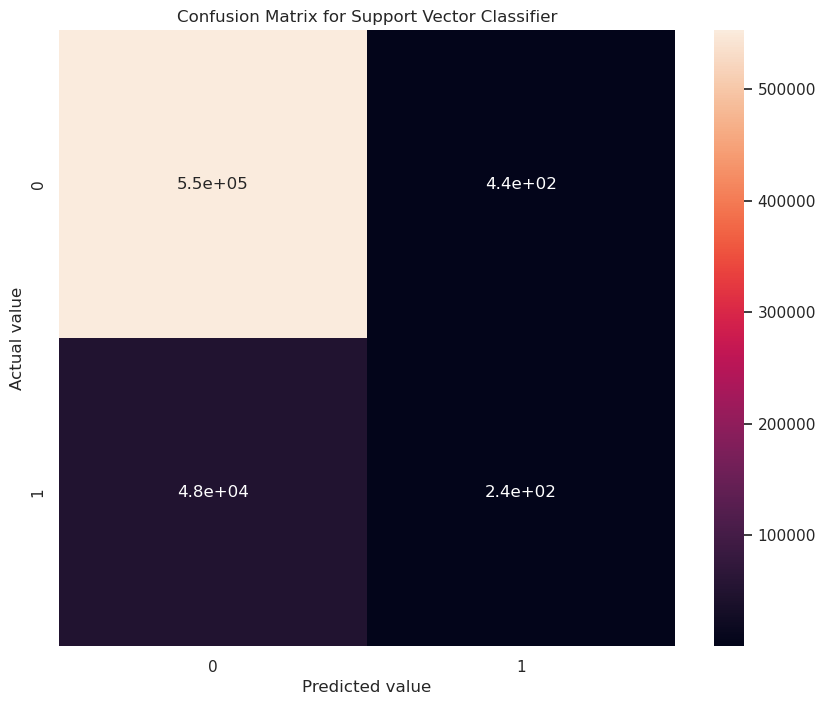

In [49]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Support Vector Classifier")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [50]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553213
           1       0.35      0.00      0.01     48412

    accuracy                           0.92    601625
   macro avg       0.64      0.50      0.48    601625
weighted avg       0.87      0.92      0.88    601625



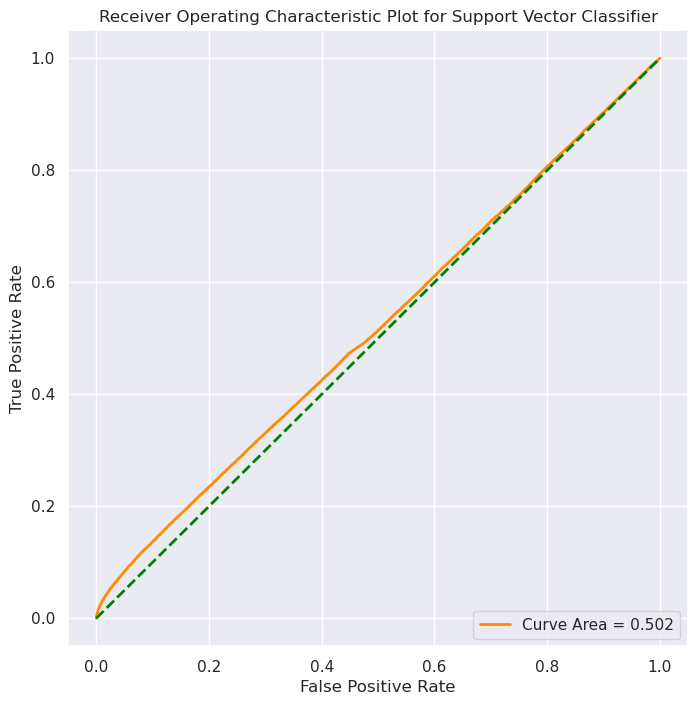

In [51]:
fpr, tpr, thr = roc_curve(Y_test, svc_lin.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Support Vector Classifier')
plt.legend(loc="lower right")
plt.show()

**Support Vector Classifier with RBF Kernel**

The Radial basis function (RBF) with Support Vector Machines have advantages of easy design, good generalization, strong tolerance to input noise, and online learning ability. The properties of RBF SVMs make it very suitable to design flexible control systems.

In [52]:
svc_rbf = SVC(kernel = "rbf", verbose = False, max_iter = 20, probability = True)
svc_rbf.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(max_iter=20, probability=True)

In [53]:
cv_accuracy = cross_val_score(svc_rbf, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
svc_rbf_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",svc_rbf_cv_accuracy)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: Conve

First fold accuracy  :  0.5181286513501693
Second fold accuracy :  0.5399835204071223
Third fold accuracy  :  0.5696198744446094
Fourth fold accuracy :  0.5118484035759199
Fifth fold accuracy  :  0.5689348026063532
Mean CV (ROC-AUC) Accuracy :  0.5417030504768349


In [54]:
cv_f1 = cross_val_score(svc_rbf, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
svc_rbf_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",svc_rbf_cv_f1)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: Conve

First fold F1  :  0.8830158233750208
Second fold F1 :  0.4282869081474848
Third fold F1  :  0.8819923875313048
Fourth fold F1 :  0.8825790946968841
Fifth fold F1  :  0.88505986899538
Mean CV F1 Score :  0.7921868165492149


In [55]:
Y_pred = svc_rbf.predict(X_test)

In [56]:
svc_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of SVC RBF is :", svc_acc)

The accuracy of SVC RBF is : 0.6280373987118222


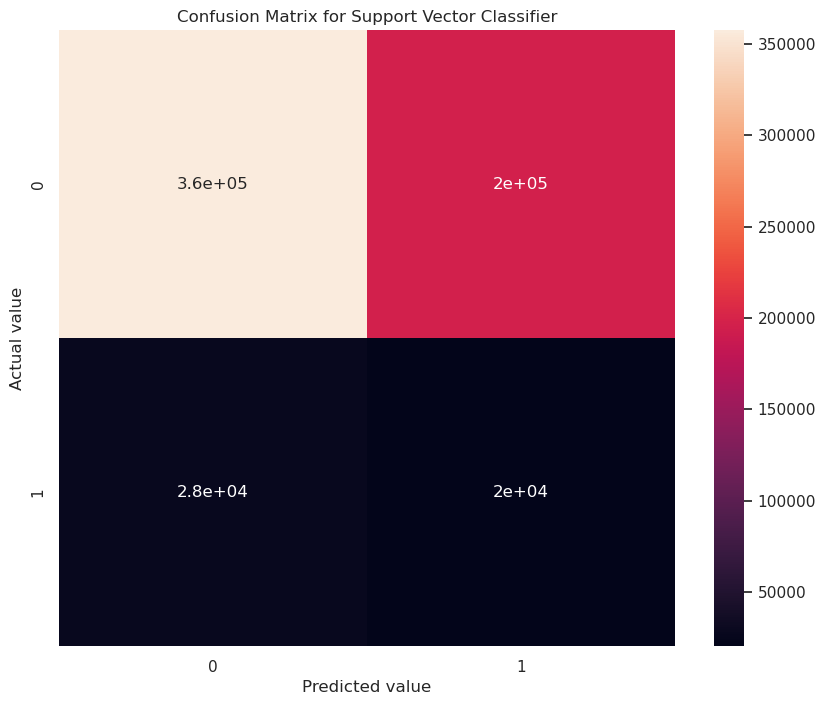

In [57]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Support Vector Classifier")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [58]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      0.65      0.76    553213
           1       0.09      0.42      0.15     48412

    accuracy                           0.63    601625
   macro avg       0.51      0.53      0.46    601625
weighted avg       0.86      0.63      0.71    601625



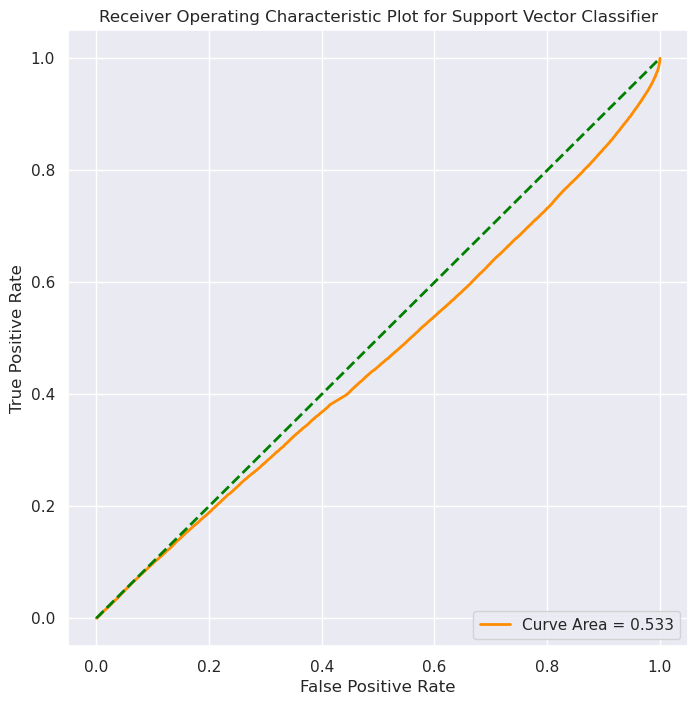

In [59]:
fpr, tpr, thr = roc_curve(Y_test, svc_rbf.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Support Vector Classifier')
plt.legend(loc="lower right")
plt.show()

**Decision Tree Classifier**

The main advantage of the decision tree classifier is its ability to using different feature subsets and decision rules at different stages of classification.

In [60]:
dc = DecisionTreeClassifier(max_depth = 10)
dc.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


DecisionTreeClassifier(max_depth=10)

In [61]:
cv_accuracy = cross_val_score(dc, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
dc_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",dc_cv_accuracy)

First fold accuracy  :  0.6296676659427244
Second fold accuracy :  0.6278054250803766
Third fold accuracy  :  0.6315908114444928
Fourth fold accuracy :  0.6281367087121845
Fifth fold accuracy  :  0.6267187443010434
Mean CV (ROC-AUC) Accuracy :  0.6287838710961644


In [62]:
cv_f1 = cross_val_score(dc, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
dc_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",dc_cv_f1)

First fold F1  :  0.919132679722931
Second fold F1 :  0.9183089175432237
Third fold F1  :  0.9189075292349378
Fourth fold F1 :  0.9175423603911866
Fifth fold F1  :  0.9178230918907501
Mean CV F1 Score :  0.9183429157566059


In [63]:
Y_pred = dc.predict(X_test)

In [64]:
dc_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of Decision Tree Classifier is :", dc_acc)

The accuracy of Decision Tree Classifier is : 0.9340702264699772


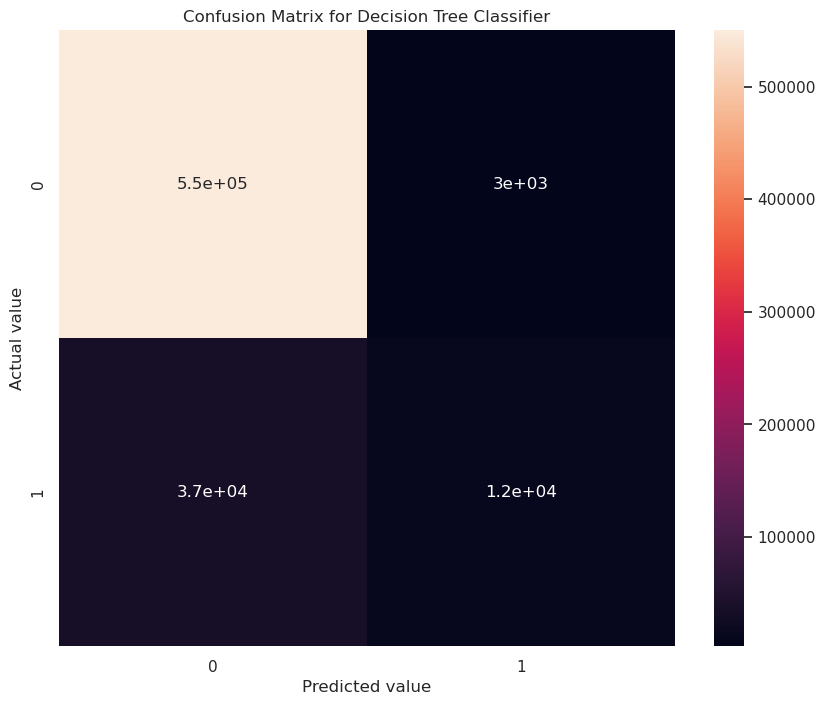

In [65]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Decision Tree Classifier")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [66]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    553213
           1       0.80      0.24      0.37     48412

    accuracy                           0.93    601625
   macro avg       0.87      0.62      0.67    601625
weighted avg       0.93      0.93      0.92    601625



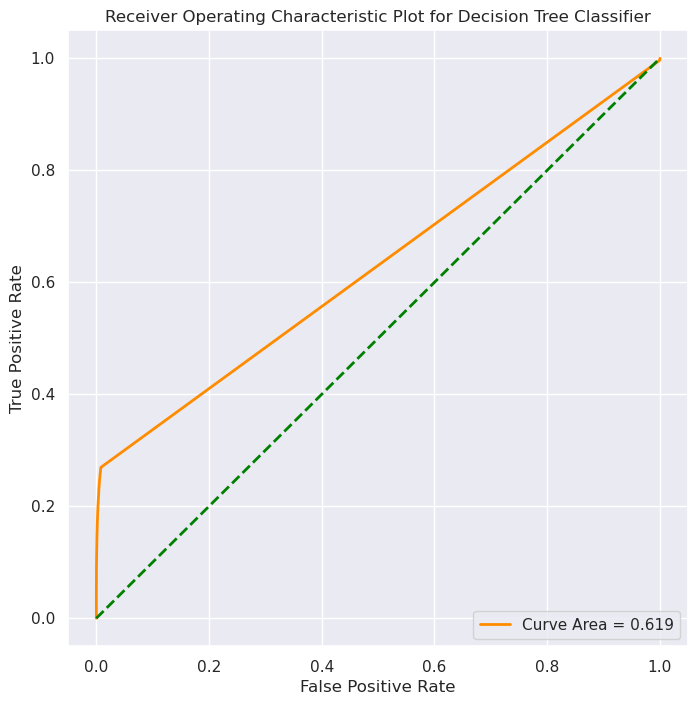

In [67]:
fpr, tpr, thr = roc_curve(Y_test, dc.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

**Random Forest Classifier**

Random Forest is a classifier that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset.

In [68]:
rf = RandomForestClassifier(n_estimators = 75,max_depth=10,verbose = 0, n_jobs = -1)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=75, n_jobs=-1)

In [69]:
cv_accuracy = cross_val_score(rf, X_train, Y_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",cv_accuracy[0])
print("Second fold accuracy : ",cv_accuracy[1])
print("Third fold accuracy  : ",cv_accuracy[2])
print("Fourth fold accuracy : ",cv_accuracy[3])
print("Fifth fold accuracy  : ",cv_accuracy[4])
rf_cv_accuracy = cv_accuracy.mean()
print("Mean CV (ROC-AUC) Accuracy : ",rf_cv_accuracy)

First fold accuracy  :  0.8165660173414373
Second fold accuracy :  0.8600711264637064
Third fold accuracy  :  0.8632884993849538
Fourth fold accuracy :  0.849995875606018
Fifth fold accuracy  :  0.8423817824400321
Mean CV (ROC-AUC) Accuracy :  0.8464606602472295


In [70]:
cv_f1 = cross_val_score(rf, X_train, Y_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",cv_f1[0])
print("Second fold F1 : ",cv_f1[1])
print("Third fold F1  : ",cv_f1[2])
print("Fourth fold F1 : ",cv_f1[3])
print("Fifth fold F1  : ",cv_f1[4])
rf_cv_f1 = cv_f1.mean()
print("Mean CV F1 Score : ",rf_cv_f1)

First fold F1  :  0.8820785223390969
Second fold F1 :  0.8820785223390969
Third fold F1  :  0.8820724653112164
Fourth fold F1 :  0.8820724653112164
Fifth fold F1  :  0.8820780394860246
Mean CV F1 Score :  0.8820760029573304


In [71]:
Y_pred = rf.predict(X_test)

In [72]:
rf_acc = accuracy_score(Y_test, Y_pred)
print("The accuracy of Random Forest Classifier is :", rf_acc)

The accuracy of Random Forest Classifier is : 0.9195312694784957


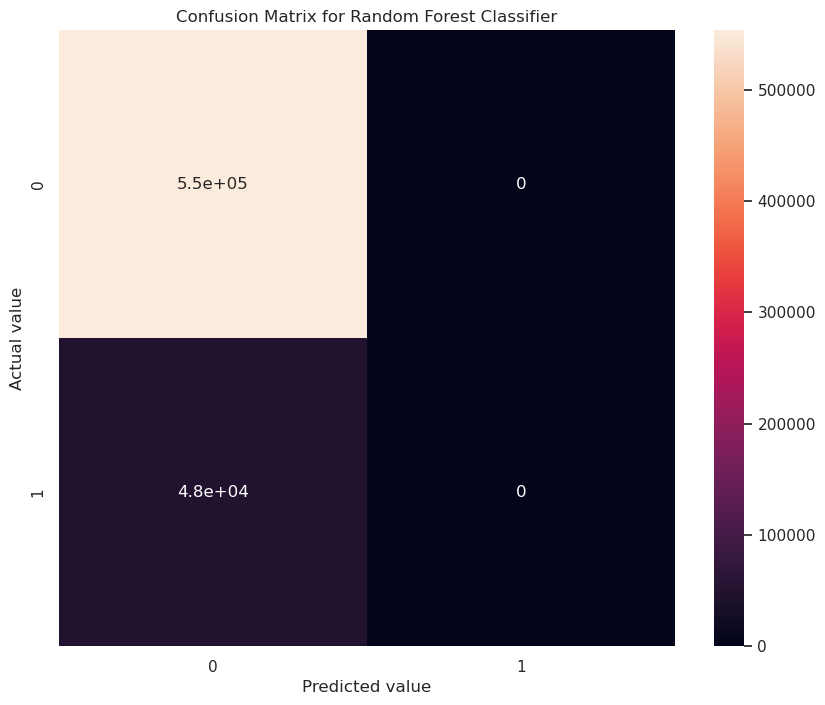

In [73]:
plt.figure(figsize=(10, 8))
mat = confusion_matrix(Y_test, Y_pred)
plt.title("Confusion Matrix for Random Forest Classifier")
sns.heatmap(mat, square=True, annot=True)
plt.xlabel('Predicted value')
plt.ylabel('Actual value');

In [74]:
print(classification_report(Y_test, Y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553213
           1       0.00      0.00      0.00     48412

    accuracy                           0.92    601625
   macro avg       0.46      0.50      0.48    601625
weighted avg       0.85      0.92      0.88    601625



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


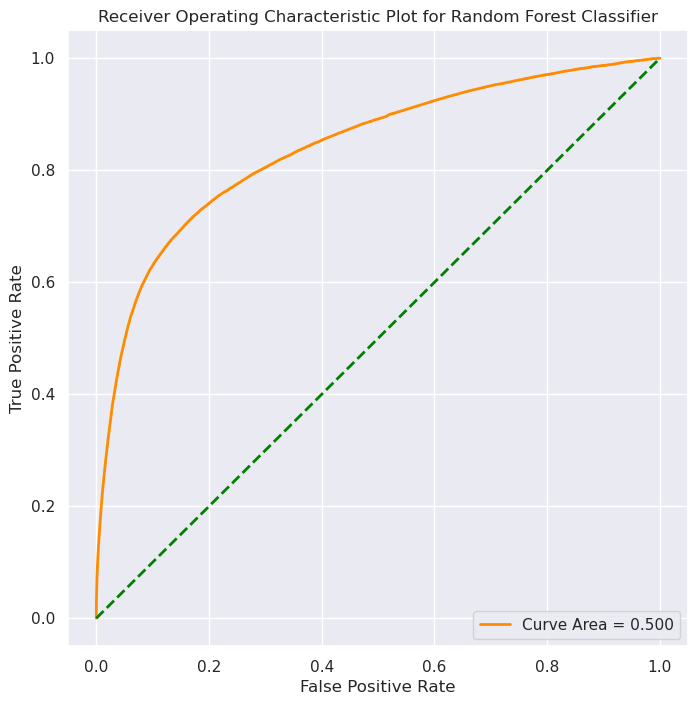

In [75]:
fpr, tpr, thr = roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, Y_pred)
lw = 2
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=lw, label="Curve Area = %0.3f" % auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

# Model Scores

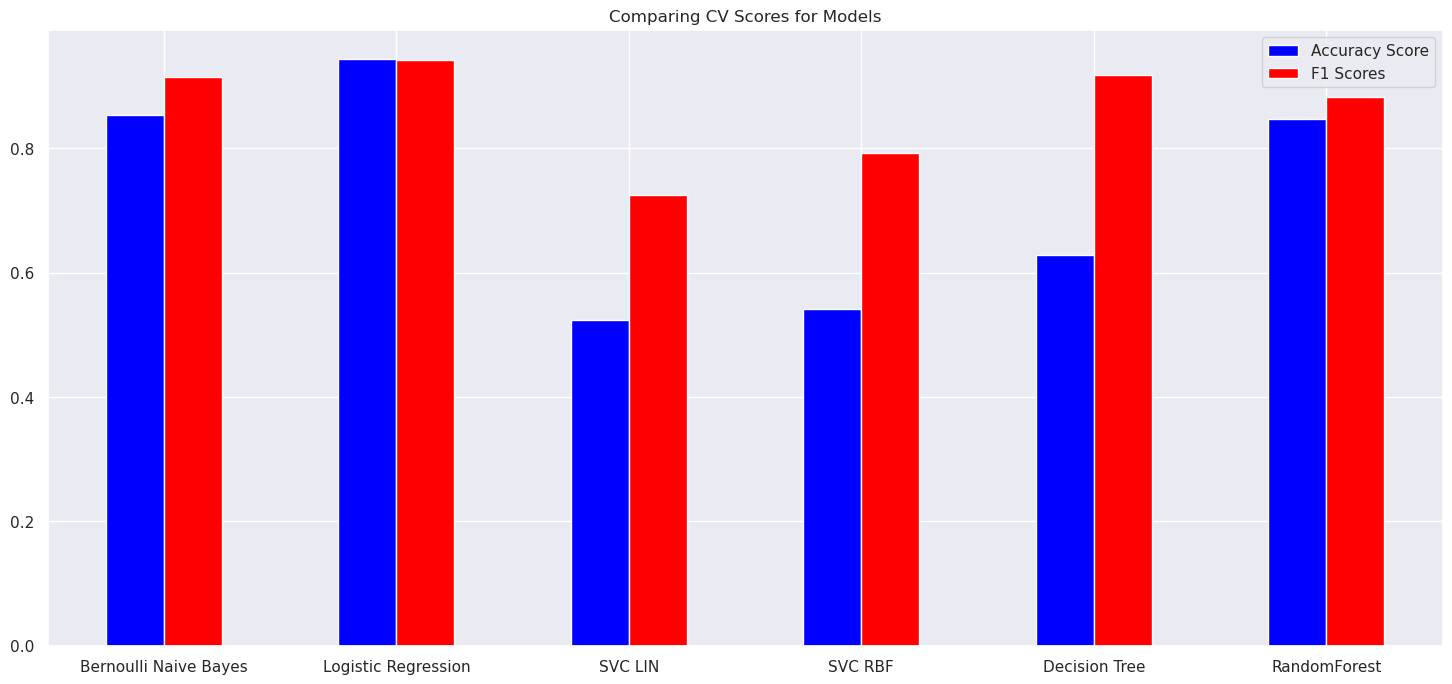

In [76]:
AccScores = [nb_cv_accuracy,lr_cv_accuracy,svc_lin_cv_accuracy,svc_rbf_cv_accuracy,dc_cv_accuracy,rf_cv_accuracy]
F1Scores = [nb_cv_f1,lr_cv_f1,svc_lin_cv_f1,svc_rbf_cv_f1,dc_cv_f1,rf_cv_f1]
indices = ['Bernoulli Naive Bayes', 'Logistic Regression', 'SVC LIN','SVC RBF','Decision Tree', 'RandomForest']

scores = pd.DataFrame({'Accuracy Score': AccScores, 'F1 Scores':F1Scores}, index=indices)
plot = scores.plot.bar(figsize=(18, 8), rot=0, color=['blue', 'red'])
plt.title('Comparing CV Scores for Models')
plt.show()

# Model Performance


**Best Models according to Accuracy**

1.   Logistic Regressor    - 94.34%
2.   Bernoulli Naive Bayes - 85.39%


**Best Models according to F1 Score**


1.   Logistic Regressor       - 94.24%
2.   Decision Tree Classifier - 91.83%

**Hence our Best performing Model is Logistic Regressor**



# Model for Submission

In [77]:
dataframe_test = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [78]:
test_X = Vectorize.transform(dataframe_test["comment_text"])

In [79]:
predictions = lr.predict_proba(test_X)[:,1]

In [80]:
submission = pd.read_csv('/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

In [81]:
submission['prediction'] = predictions
submission.to_csv('submission.csv', index=False)

In [82]:
submission.head()

,id,prediction
0,7097320,0.039710
1,7097321,0.045314
2,7097322,0.079036
3,7097323,0.022333
4,7097324,0.004591
